<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aiport-data" data-toc-modified-id="Aiport-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aiport data</a></span></li><li><span><a href="#Get-all-weather-data-..." data-toc-modified-id="Get-all-weather-data-...-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get all weather data ...</a></span></li><li><span><a href="#...-and-extract-weather-close-to-airports" data-toc-modified-id="...-and-extract-weather-close-to-airports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>... and extract weather close to airports</a></span></li><li><span><a href="#Weather-patterns" data-toc-modified-id="Weather-patterns-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Weather patterns</a></span></li><li><span><a href="#Correlations-from-top-10-pairs" data-toc-modified-id="Correlations-from-top-10-pairs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlations from top 10 pairs</a></span></li></ul></div>

# Aiport data

Combine airport codes and top airports into a table with relevant info (name, wikipedia link, latitude, longitute).

In [1]:
import pandas as pd

# load top 50 airports
top50 = pd.read_csv("hw_5_data/top_airports.csv")
top50_mini = top50[["ICAO", "Airport"]]

# load aiport info
codes = pd.read_csv("hw_5_data/ICAO_airports.csv")
codes_mini = codes[["ident", "latitude_deg", "longitude_deg", "wikipedia_link"]]
codes_mini = codes_mini.rename(columns={'ident': "ICAO"})

# combine data into one table
data = pd.merge(top50_mini, codes_mini, how="left", on="ICAO")

Load this table into a database.

In [2]:
from sqlalchemy import *

# initiate engine
engine = create_engine("sqlite:///airport_info.db")

# convert pd to list
data.to_sql(name='airports', con=engine)


50

# Get all weather data ... 
# ... and extract weather close to airports

In [3]:
## if need to reload data, just do this instead to save time!
# import xarray as xr
# airport_weather = xr.open_dataset('airport_weather.nc')

Get historical weather information (min/max temperature, relative humidity, perciptation) for 1990-2000 from dataset used in class (with xarray/netCDF4).

In [4]:
# load weather data!

import xarray as xr
# temp: tasmax/tasmin, RH: rhsmax/rhsmin, precipitation: pr

datatypes = ["tasmax", "tasmin", "rhsmax", "rhsmin", "pr"]
datatypes_str = ["air_temperature", "air_temperature", "relative_humidity", "relative_humidity", "precipitation"]
datatypes_nice = ["air_temperature_max", "air_temperature_min", "relative_humidity_max", "relative_humidity_min", "precipitation"]

storage = []
for i in range(len(datatypes)):
    
    data_path = ("http://thredds.northwestknowledge.net:8080/"
                 f"thredds/dodsC/agg_macav2metdata_{datatypes[i]}"
                 "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc"
                )
    storage.append(xr.open_dataset(data_path).rename({datatypes_str[i] : datatypes_nice[i]}))


# combine all data types
weather_data = xr.merge(storage)

# reduce to time window of interest
time_window = pd.date_range(start='1/1/1990', end='12/31/2000', freq='D')
weather_data = weather_data.sel(time=time_window)

Just keep weather data for coordinates closest to each aiport.

In [5]:
# for each airport, find closest (long, lat) in weather data

import numpy as np


def find_closest(weather_long, weather_lat, this_long, this_lat):
    """
    Find the closest weather station to aiport longitude and 
    latitude coordinates.
    
    Parameters
    ----------
    weather_long : np array
        Vector of floats with longitude coordinates for all weather stations
    weather_lat : np array
        Vector of floats with latitude coordinates for all weather stations
    this_long : float
        Longitude coordinate for this airport
    this_lat : float
        Latitude coordinate for this airport
        
    Returns
    -------
    idx : int
        Index for closest weather station
        
    """
    # convert weather long coordinates to match expected for aiport
    weather_long_adjusted = weather_long - 360
    
    # find closest long idx:
    long_idx = np.abs(weather_long_adjusted - this_long).argmin()
    
    # find closest lat idx:
    lat_idx = np.abs(weather_lat - this_lat).argmin()
    
    return long_idx, lat_idx

# extract all of the long, lat coordinates from the weather data
weather_long = weather_data["lon"].values
weather_lat = weather_data["lat"].values

# extract all of the airport long, lat coordinates 
airport_long = engine.execute("SELECT longitude_deg FROM airports").fetchall()
airport_lat = engine.execute("SELECT latitude_deg FROM airports").fetchall()

# get airport names
airport_ICAO = engine.execute("SELECT ICAO FROM airports").fetchall()

# identify the closest weather station for each airport
weather_idx = [find_closest(weather_long, weather_lat, airport_long[i][0], airport_lat[i][0]) 
               for i in range(len(airport_long))] # (long, lat)

In [6]:
# pull out weather data closest to each airport and concat into a new xarray
storage = []
for i in range(len(airport_ICAO)):
    port_data = weather_data.sel(lon=weather_long[weather_idx[i][0]], 
                                 lat=weather_lat[weather_idx[i][1]])
    storage.append(port_data.assign_coords({"airport_ICAO": airport_ICAO[i][0]}).drop(["lon","lat","crs"]))


In [7]:
%%time
airport_weather = xr.concat(storage, "airport_ICAO", coords="different") 
airport_weather.to_netcdf('airport_weather.nc')
airport_weather

CPU times: user 815 ms, sys: 228 ms, total: 1.04 s
Wall time: 11min 8s


<xarray.Dataset>
Dimensions:                (time: 4018, airport_ICAO: 50)
Coordinates:
  * time                   (time) datetime64[ns] 1990-01-01 ... 2000-12-31
  * airport_ICAO           (airport_ICAO) <U4 'KATL' 'KORD' ... 'KDAL' 'KIND'
Data variables:
    air_temperature_max    (airport_ICAO, time) float32 293.6 295.3 ... 274.7
    air_temperature_min    (airport_ICAO, time) float32 273.1 274.8 ... 267.1
    relative_humidity_max  (airport_ICAO, time) float32 67.16 62.87 ... 85.66
    relative_humidity_min  (airport_ICAO, time) float32 23.18 25.62 ... 56.02
    precipitation          (airport_ICAO, time) float32 0.0 0.0 ... 0.0 0.0
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   GRID
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

This method of concatenating data is pretty slow... need to look for a better way to flatten the weather (long, lat) coordinates to restrict to the top airports.

# Weather patterns

I'll compare the temperature and precipitation at pairs of aiports by correlating the timeseries. I'm assuming we're interested in comparisons between different airports, so I'll set the diagonal = 0.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def get_shifty_corr(variable, lag):
    """Calculate pairwise correlations between rows in 
    variable matrix (with lag).
    
    Parameters
    ----------
    variable : np array or x array
        2D array (airports x time) for variable (e.g. max temperature, precipitation)
    lag : int
        Number of offset days between correlations
        
    Returns
    -------
    corrcoeffs : np array
        2D array (airports x airports) with pairwise correlations; columns shifted lag before rows
        
    """
    # get number of aiports
    n_ports, n_time = variable.shape

    # make array for correlation coefficients
    corrcoeffs = np.empty((n_ports, n_ports))
    
    for port0 in range(n_ports):
        for port1 in range(n_ports):
            corrcoeffs[port0, port1] = np.corrcoef(variable[port0, lag:],
                                                  variable[port1, :n_time-lag])[0, 1]

    # set diag to 0
    corrcoeffs[np.eye(50)==1] = 0
    
    return corrcoeffs

**This is the correlation of max temperature and precipitation between all airports (with no lag):**

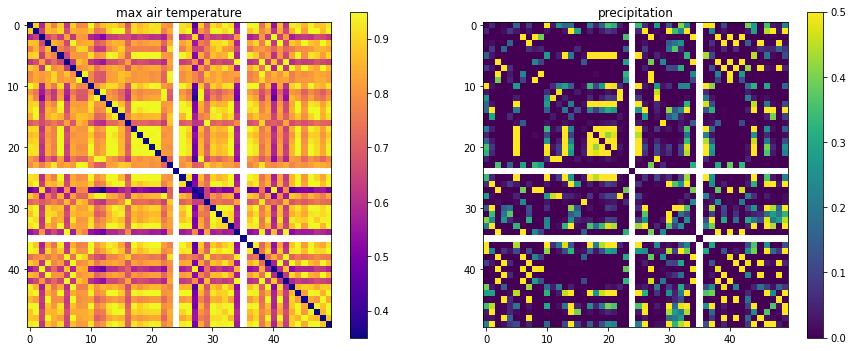

In [9]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1,2,1)
temp_corr0 = get_shifty_corr(airport_weather["air_temperature_max"], 0)
temp_heat = ax.imshow(temp_corr0, cmap="plasma", vmin=0.35, vmax=0.95)
ax.title.set_text("max air temperature")
fig.colorbar(temp_heat)

ax = fig.add_subplot(1,2,2)
prec_corr0 = get_shifty_corr(airport_weather["precipitation"], 0)
prec_heat = ax.imshow(prec_corr0, cmap="viridis", vmin=0, vmax=0.5)
ax.title.set_text("precipitation")
fig.colorbar(prec_heat)


**This is the correlation of max temperature between all airports with lags of 1, 3, or 7 days (columns = shifted before rows):**

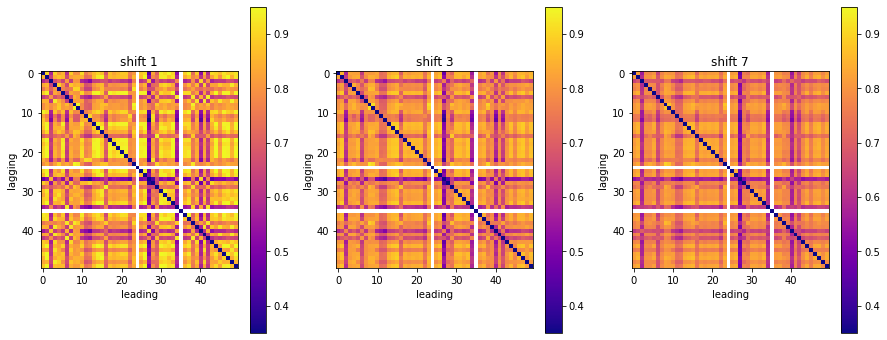

In [10]:
daily_lag = [1, 3, 7]
n_lags = len(daily_lag)

temp_corr_lag = [get_shifty_corr(airport_weather["air_temperature_max"], d) for d in daily_lag]

fig = plt.figure(figsize=(15, 6))
for d in range(n_lags):
    ax = fig.add_subplot(1, n_lags, d+1)
    heat = ax.imshow(temp_corr_lag[d], cmap="plasma", vmin=0.35, vmax=0.95)
    
    ax.set(xlabel="leading", ylabel="lagging", title=f"shift {daily_lag[d]}")
    fig.colorbar(heat)

**This is the correlation of precipitation between all airports with lags of 1, 3, or 7 days (columns = shifted before rows):**

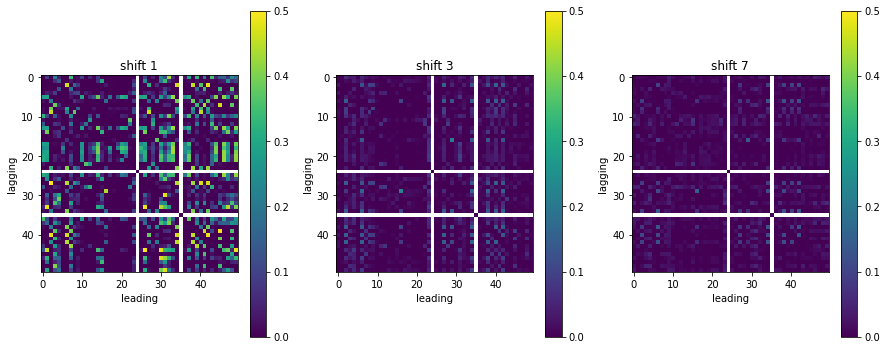

In [11]:
prec_corr_lag = [get_shifty_corr(airport_weather["precipitation"], d) for d in daily_lag]

fig = plt.figure(figsize=(15, 6))
for d in range(n_lags):
    ax = fig.add_subplot(1, n_lags, d+1)
    heat = ax.imshow(prec_corr_lag[d], cmap="viridis", vmin=0, vmax=0.5)
    
    ax.set(xlabel="leading", ylabel="lagging", title=f"shift {daily_lag[d]}")
    fig.colorbar(heat)
    

# Correlations from top 10 pairs

In [12]:
# For a given correlation matrix, find the long and lat coordinates of the top pairs

def pull_top_pairs(corrcoeffs, n_pairs, airport_long, airport_lat):
    """Find the top n_pairs; return values and 
    (long, lat) coordinates of ports in pairs.
    
    Parameters
    ----------
    corrcoeffs : np array
        2D array (airports x airports) with pairwise correlations; columns shifted lag before rows
    n_pairs : int
        Number of top pairs 
    airport_long : np array
        Vector of airport longitude coordinates
    airport_lat : np array
        Vector of aiport latitude coordinates
        
    Returns
    -------
    top_values : np array
        Vector with top correlations
    top_long : np array
        Vector of tuples with long coordinates for airports in pairs
    top_lat : np array
        Vector of tuples with lat coordinates for aiports in pairs
    
    """
    # get number of aiports
    n_ports = corrcoeffs.shape[0]
    
    # get top n_pairs 
    top_idx = np.argsort(-corrcoeffs, axis=None)[:10] # ravelled index
    top_xy = np.unravel_index(top_idx, (n_ports, n_ports)) # get (row, col) index
    
    # get the corr for these pairs
    top_values = [corrcoeffs[top_xy[0][i], top_xy[1][i]] 
                  for i in range(n_pairs)]
    
    # get longitude coords for pair
    top_long = [(airport_long[top_xy[0][i]][0], airport_long[top_xy[1][i]][0])
               for i in range(n_pairs)]
    
    # get latitude coords for pair
    top_lat = [(airport_lat[top_xy[0][i]][0], airport_lat[top_xy[1][i]][0])
               for i in range(n_pairs)]
    
    return top_values, top_long, top_lat

**Top temperature correlations as a function of distance:**

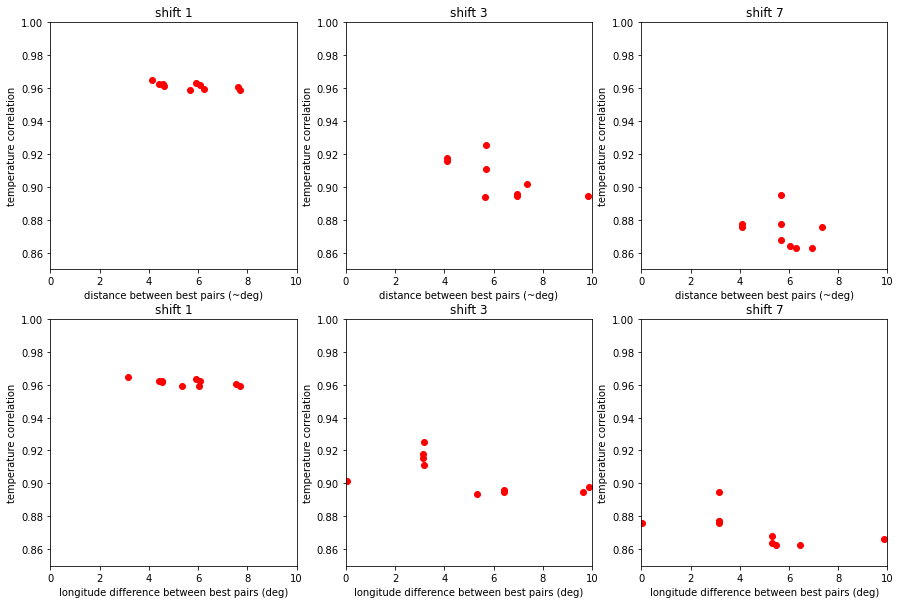

In [13]:
fig = plt.figure(figsize=(15, 10))

for d in range(n_lags):
    
    # get top 10 pairs
    top_values, top_long, top_lat = pull_top_pairs(temp_corr_lag[d], 10, airport_long, airport_lat)
    
    # cartesian distance
    cart_dist = [((long[0] - long[1]) ** 2 + (lat[0] - lat[1]) ** 2) ** 0.5 
                 for long, lat in zip(top_long, top_lat)]
    
    # longitude distance
    long_dist = [np.abs(long[0] - long[1]) for long in top_long]
    
    # plot value vs cart dist
    ax = fig.add_subplot(2, n_lags, d+1)
    ax.scatter(cart_dist, top_values, color='r')
    ax.set(xlabel="distance between best pairs (~deg)", 
           ylabel="temperature correlation", 
           title=f"shift {daily_lag[d]}",
           xlim=[0, 10],
           ylim=[0.85, 1])
    
    # plot value vs long dist
    ax = fig.add_subplot(2, n_lags, d+1+n_lags)
    ax.scatter(long_dist, top_values, color='r')
    ax.set(xlabel="longitude difference between best pairs (deg)", 
           ylabel="temperature correlation", 
           title=f"shift {daily_lag[d]}",
           xlim=[0, 10],
           ylim=[0.85, 1])


Temperature correlations for the most tightly linked airport pairs decreased with longer lags (1 --> 7 days) but remained quite high overall (> 0.85), as expected given the relatively slow annual cycle in temperature. The best pairs spanned approximately the same range of distances for all lags. Airports with similar temperature trends were at similar latitudes: the distance range for the top pairs was very similar if measured as a function of longitude and latitude or just longitude alone.

(I used cartesian coordinates to approximate the distance between (long, lat) coordinates to simplify calculations. It would be more correct to calculate the distance along the sphere surface.)

**Top precipitation correlations as a function of distance:**

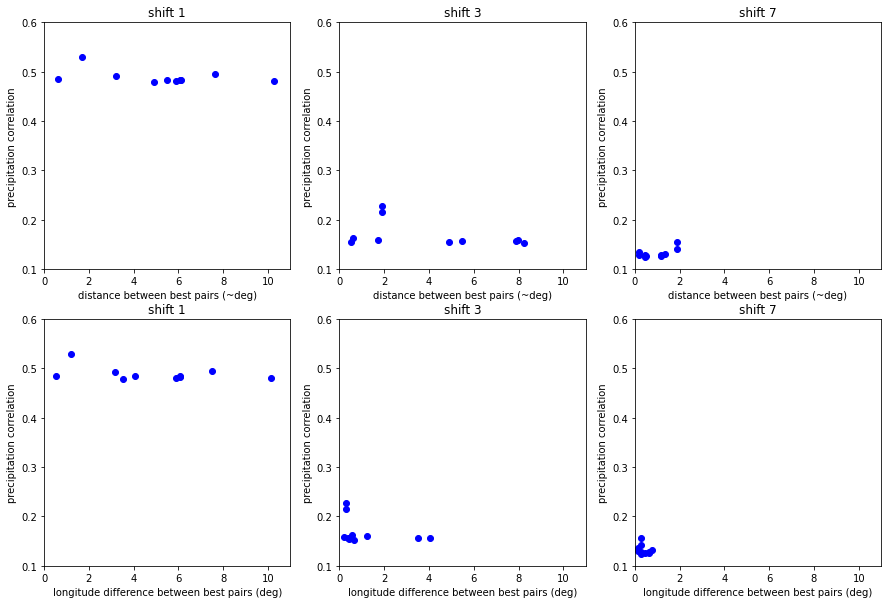

In [14]:
fig = plt.figure(figsize=(15, 10))

for d in range(n_lags):
    
    # get top 10 pairs
    top_values, top_long, top_lat = pull_top_pairs(prec_corr_lag[d], 10, airport_long, airport_lat)
    
    # cartesian distance
    cart_dist = [((long[0] - long[1]) ** 2 + (lat[0] - lat[1]) ** 2) ** 0.5 
                 for long, lat in zip(top_long, top_lat)]
    
    # longitude distance
    long_dist = [np.abs(long[0] - long[1]) for long in top_long]
    
    # plot value vs cart dist
    ax = fig.add_subplot(2, n_lags, d+1)
    ax.scatter(cart_dist, top_values, color='b')
    ax.set(xlabel="distance between best pairs (~deg)", 
           ylabel="precipitation correlation", 
           title=f"shift {daily_lag[d]}",
           xlim=[0, 11],
           ylim=[0.1, 0.6])
    
    # plot value vs long dist
    ax = fig.add_subplot(2, n_lags, d+1+n_lags)
    ax.scatter(long_dist, top_values, color='b')
    ax.set(xlabel="longitude difference between best pairs (deg)", 
           ylabel="precipitation correlation", 
           title=f"shift {daily_lag[d]}",
           xlim=[0, 11],
           ylim=[0.1, 0.6])


Peak precipitation correlations fell from ~0.5 to ~0.1-0.2 within a couple of days, and the distance between the best pairs decreased from up to 10 deg to up to 2 deg. This is reasonable, since precipitation patterns are more local than temperature and can change daily.